In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('referenceData.csv')
#print(df.columns)


spectral_bands = ['blue','green','red','nir','swir1','swir2']
x_values = [x for x in range(len(spectral_bands))]
classes = df['LC09_6'].unique()
class_names = [str(c) for c in classes]
mean_data = []
std_data = []

for land_cover_class in classes:
    class_df = df.loc[df['LC09_6'] == land_cover_class]
    class_means = []
    class_stds = []
    for band in spectral_bands:
        class_band_values = np.array(class_df[band]/10000)
        class_means.append(np.mean(class_band_values))
        class_stds.append(np.std(class_band_values))
    mean_data.append(class_means)
    std_data.append(class_stds)
    
fig, axs = plt.subplots(2,2, figsize=(16,8), facecolor='w', edgecolor='k') #sharey=True
fig.subplots_adjust(hspace=0.4, wspace=0.2)

axs = axs.ravel()
linestyle = {"linestyle":"-", "linewidth":1, "markeredgewidth":1, "elinewidth":1, "capsize":4}

for i in range(len(classes)):
    ax = axs[i]
    ax.set_title(class_names[i],fontdict={'fontsize': 16, 'fontweight': 'bold'}) 
    ax.errorbar(x_values, mean_data[i], yerr = std_data[i], color="k", **linestyle)
    ax.set_ylim([0, 0.5])
    yticklabels = [round(x,1) for x in list(np.linspace(0,0.5,6))]
    ax.set_xticks(x_values)
    ax.set_xticklabels(spectral_bands,fontdict={'fontsize': 12})
    ax.set_yticklabels(yticklabels,fontdict={'fontsize': 12})
    #ax.set_xlabel('Spectral band')
    #ax.set_ylabel('Surface reflectance')

fig.text(0.5, 0.02, 'Spectral band', ha='center',fontweight='bold',fontsize=16)
fig.text(0.06, 0.5, 'Surface reflectance', va='center', rotation='vertical',fontweight='bold',fontsize=16)
plt.savefig('reference_spectra.png', dpi=300, bbox_inches = "tight")
plt.show()



FileNotFoundError: [Errno 2] File b'referenceData.csv' does not exist: b'referenceData.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('labeledReferenceData.csv')
#print(df.columns)


spectral_bands = ['blue','green','red','nir','swir1','swir2']
x_values = [x for x in range(len(spectral_bands))]
classes = df['LC09_6'].unique()
class_names = ['Urban','Grass','Forest','Water']
class_colors = ['#FF0000','#FFFF00','#00B200','#0000FF']
mean_data = []
std_data = []
dates = [0]

for land_cover_class in classes:
    class_df = df.loc[df['LC09_6'] == land_cover_class]
    class_means = []
    class_stds = []
    for band in spectral_bands:
        class_band_values = np.array(class_df[band]/10000)
        class_means.append(np.mean(class_band_values))
        class_stds.append(np.std(class_band_values))
    mean_data.append(class_means)
    std_data.append(class_stds)
    
fig, axs = plt.subplots(2,1, figsize=(16,16), facecolor='w', edgecolor='k') #sharey=True
fig.subplots_adjust(hspace=0.4, wspace=0.2)

axs = axs.ravel()
linestyle = {"linestyle":"-", "linewidth":1, "markeredgewidth":1, "elinewidth":1, "capsize":4}

for i in range(len(dates)):
    ax = axs[i]
    ax.set_title(dates[i],fontdict={'fontsize': 20, 'fontweight': 'bold'}) 
    errorbars = []
    for j in range(len(classes)):
        
        errorbar = ax.errorbar(x_values, mean_data[j], yerr = std_data[j], label=class_names[j], color=class_colors[j], **linestyle)
        errorbars.append(errorbar)
        # ax.legend(loc="upper right")
        ax.set_ylim([0, 0.5])
        yticklabels = [round(x,1) for x in list(np.linspace(0,0.5,6))]
        ax.set_xticks(x_values)
        ax.set_xticklabels(spectral_bands,fontdict={'fontsize': 20})
        ax.set_yticklabels(yticklabels,fontdict={'fontsize': 20})
        #ax.set_xlabel('Spectral band')
        #ax.set_ylabel('Surface reflectance')
    
    # get handles
    handles, labels = ax.get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # use them in the legend
    ax.legend(handles, labels, loc='upper left',numpoints=1)
    
fig.text(0.5, 0.02, 'Spectral band', ha='center',fontweight='bold',fontsize=20)
fig.text(0.06, 0.5, 'Surface reflectance', va='center', rotation='vertical',fontweight='bold',fontsize=20)
# plt.savefig('reference_spectra.png', dpi=300, bbox_inches = "tight")
plt.show()


reference_data_2007_roi1_91.csv


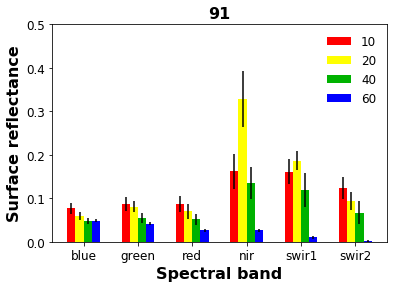

reference_data_2007_roi1_182.csv


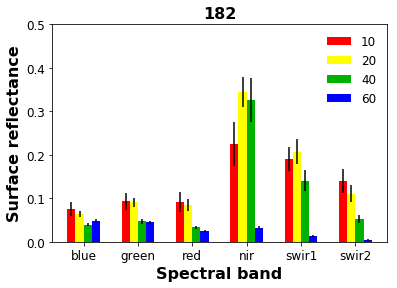

reference_data_2007_roi1_273.csv


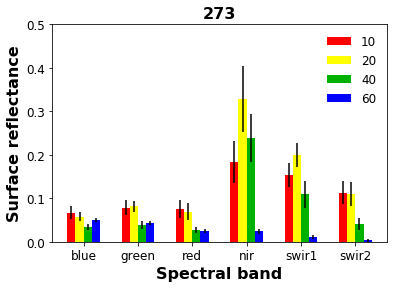

In [2]:
"""
Script to analyse the spectral signature of the reference data
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



# these parameters can be changed

# run for different region of interests 
roi = 'roi1'

# year of data acquisition
year = 2007

# select scenario
scenario = 2



# function to extract the mean and standard deviation values for each class and spectral channel
def extract_data(file_name):
    df = pd.read_csv(file_name)
    
    classes = sorted(df['LC09_6'].unique())
    class_names = [str(c) for c in classes]
    mean_data = []
    std_data = []
    
    for land_cover_class in classes:
        
        class_df = df.loc[df['LC09_6'] == land_cover_class]
        class_means = []
        class_stds = []
        
        for band in spectral_bands:
            class_band_values = np.array(class_df[band]/10000)
            class_means.append(np.mean(class_band_values))
            class_stds.append(np.std(class_band_values))
        
        mean_data.append(class_means)
        std_data.append(class_stds)
    
    return classes, mean_data, std_data



# select temporal features according to chosen scenario
if scenario==1:
    temporal_features = [182]
elif scenario==2:
    temporal_features = [91,182,273]
elif scenario==3:
    temporal_features = [52, 104, 156, 208, 260, 312]
elif scenario==4:
    temporal_features = [36, 73, 109, 146, 182, 219, 255, 292, 328]
elif scenario==5:
    temporal_features = [28, 56, 84, 112, 140, 168, 196, 224, 252, 280, 308, 336]
else:
    print('unkown scenario')



name = 'reference_data'
extension = '.csv'
colors = {'10': '#FF0000','20': '#FFFF00','30': '#B2B200','40': '#00B200','50': '#804D33','60': '#0000FF'}
spectral_bands = ['blue','green','red','nir','swir1','swir2']
x_values = [x for x in range(len(spectral_bands))]
n = len(spectral_bands)
x_pos = np.arange(n)  # the x locations for the groups
width = 0.15       # the width of the bars
path = 'data/'+roi+'/'
y_min = 0
y_max = 0.5



# iterate over the temporal features and generate plot for each one
for i, doy in enumerate(temporal_features):
    file_name = name+'_'+str(year)+'_'+roi+'_'+str(doy)+extension
    print(file_name)
    classes, mean_data, std_data = extract_data(path+file_name)
    class_names = [str(c) for c in classes]
    
    fig, ax = plt.subplots()
    
    for i, land_cover_class in enumerate(classes):
        ax.bar(x_pos+i*width, mean_data[i], width, color=colors[str(land_cover_class)], yerr=std_data[i],label=land_cover_class)
    
    # add some text for labels, title and axes ticks
    ax.set_xlabel('Spectral band',fontdict={'size': 16, 'weight': 'bold'})
    ax.set_ylabel('Surface reflectance',fontdict={'size': 16, 'weight': 'bold'})
    ax.set_title(str(doy),fontdict={'size': 16, 'weight': 'bold'})
    ax.set_xticks(x_pos-width/2+(len(classes)*width/2))
    ax.set_xticklabels(spectral_bands, fontdict={'fontsize': 12})
    ax.set_ylim([y_min,y_max])
    ax.set_yticks(np.linspace(y_min,y_max,6))
    ax.set_yticklabels([round(y,2) for y in list(np.linspace(y_min,y_max,6))], fontdict={'fontsize': 12})

    plt.legend(loc=0, prop={'size': 12},frameon=False)
    plt.show()
    
    # end of plotting loop


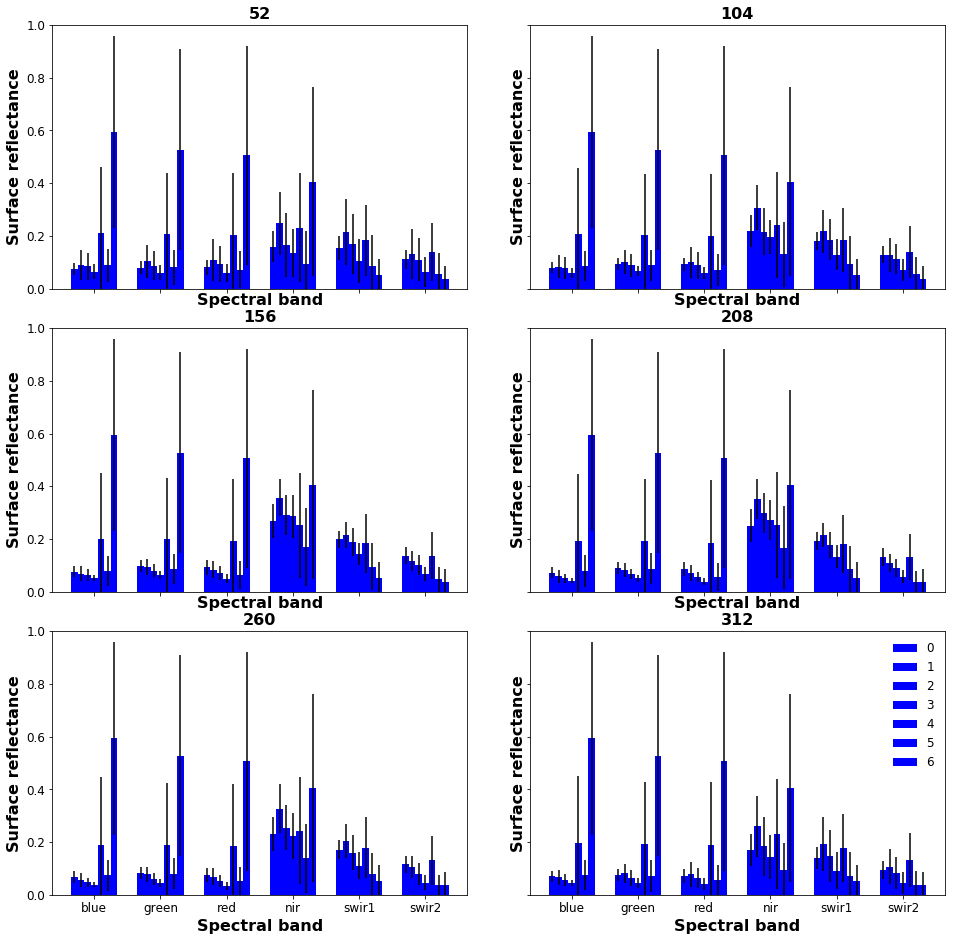

In [6]:
"""
Script to analyse the spectral signature of the reference data
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



""" //////////////////////// global variables //////////////////////// """

spectral_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']

scenario1 = [182]  
scenario2 = [91,182,273]
scenario3 = [52, 104, 156, 208, 260, 312]
scenario4 = [36, 73, 109, 146, 182, 219, 255, 292, 328]
scenario5 = [28, 56, 84, 112, 140, 168, 196, 224, 252, 280, 308, 336]

classes = [i for i in range(7)]



""" //////////////////////// main //////////////////////// """

doys = scenario3


rois = ['roi1','roi2','roi3']
label = 'land_cover'

file_names = [f'D:/thesis/scripts/data/arealstatistik/{roi}/{roi}_as_labeled.csv' for roi in rois]
list_dfs = [pd.read_csv(file_name) for file_name in file_names]
data = pd.concat(list_dfs)


fontsize = 16

n_plots = len(doys)
n_columns = 2
n_rows = n_plots//2
fig, axs = plt.subplots(n_rows,n_columns, figsize=(16,16), facecolor='w', edgecolor='k', sharex=True, sharey=True) #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.15, wspace=0.15)
axs = axs.ravel()



colors = {'10': '#FF0000','20': '#FFFF00','30': '#B2B200','40': '#00B200','50': '#804D33','60': '#0000FF'}
x_values = [x for x in range(len(spectral_bands))]
n = len(spectral_bands)
x_pos = np.arange(n)  # the x locations for the groups
width = 0.1       # the width of the bars
y_min = 0
y_max = 1



# iterate over the temporal features and generate plot for each one
for idoy, doy in enumerate(doys):
    
    ax = axs[idoy]
    
    for ic, c in enumerate(classes):
        
        df_class = data[data['land_cover']==c]
        
        # get mean and std for that class for each band
        means = []
        stds = []
        for band in spectral_bands:
            feature_name = f'{band}_{doy}'
            values = np.array(df_class[feature_name]/10000)
            means.append(np.mean(values))
            stds.append(np.std(values))
        
        
        ax.bar(x_pos+ic*width, means, width, color='#0000FF', yerr=stds,label=ic)
    
    # add some text for labels, title and axes ticks
    ax.set_xlabel('Spectral band',fontdict={'size': 16, 'weight': 'bold'})
    ax.set_ylabel('Surface reflectance',fontdict={'size': 16, 'weight': 'bold'})
    ax.set_title(str(doy),fontdict={'size': 16, 'weight': 'bold'})
    ax.set_xticks(x_pos-width/2+(len(classes)*width/2))
    ax.set_xticklabels(spectral_bands, fontdict={'fontsize': 12})
    ax.set_ylim([y_min,y_max])
    ax.set_yticks(np.linspace(y_min,y_max,6))
    ax.set_yticklabels([round(y,2) for y in list(np.linspace(y_min,y_max,6))], fontdict={'fontsize': 12})

plt.legend(loc=0, prop={'size': 12},frameon=False)
plt.show()
    
    # end of plotting loop


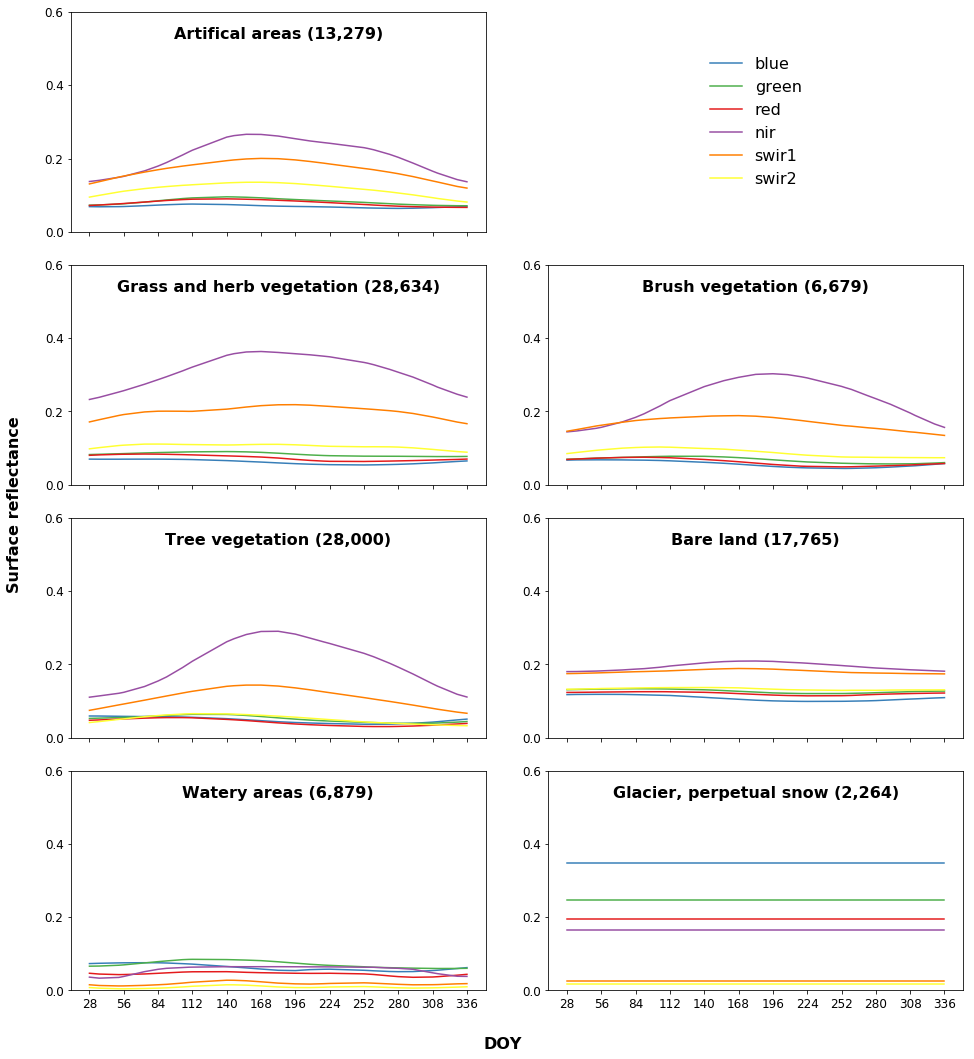

In [14]:
"""
Script to analyse the spectral signature of the reference data
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



""" //////////////////////// global variables //////////////////////// """

spectral_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']

doys = [28,36,52,56,73,84,91,104,109,112,140,146,156,168,182,196,208,219,224,252,255,260,273,280,292,308,312,328,336]

classes = np.arange(7)

class_names = [
    'Artifical areas',
    'Grass and herb vegetation',
    'Brush vegetation',
    'Tree vegetation',
    'Bare land',
    'Watery areas',
    'Glacier, perpetual snow'
]

colors = [
    
    '#377eb8',
    '#4daf4a',
    '#e41a1c',
    '#984ea3',
    '#ff7f00',
    '#ffff33'
]

""" //////////////////////// main //////////////////////// """


rois = ['roi1','roi2','roi3']
label = 'land_cover'

file_names = [f'D:/thesis/scripts/data/arealstatistik/{roi}/{roi}_as_labeled.csv' for roi in rois]
list_dfs = [pd.read_csv(file_name) for file_name in file_names]
data = pd.concat(list_dfs)


fontsize = 16

n_plots = len(classes)
n_columns = 2
n_rows = 4
fig, axs = plt.subplots(n_rows,n_columns, figsize=(16,18), facecolor='w', edgecolor='k', sharex=True)
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.15, wspace=0.15)
axs = axs.ravel()



# iterate over the temporal features and generate plot for each one
for ic, c in enumerate(classes):
    
    ax = axs[ic] if ic<1 else axs[ic+1]
    df_class = data[data['land_cover']==ic]
    count = df_class.shape[0]
    lines = []

    
    for iband, band in enumerate(spectral_bands):
        
        means, medians, stds = ([],[],[])
        
        for doy in doys:
            feature_name = f'{band}_{doy}'
            values = np.array(df_class[feature_name]/10000)
            means.append(np.mean(values))
            medians.append(np.median(values))
            stds.append(np.std(values))


        lines += ax.ploccccccccccccccct(doys, medians, label=band, color=colors[iband])
    
    
    ax.set_title(
        f'{class_names[ic]} ({count:,d})',
        fontdict={'size': fontsize, 'weight': 'bold'},
        position=(0.5, 0.85)
    )
    
    
    y_min, y_max = (0,0.6)
    ax.set_ylim((y_min,y_max))
    ax.set_yticks(np.linspace(y_min,y_max,4))
    ax.set_yticklabels([round(y,2) for y in list(np.linspace(y_min,y_max,4))], fontdict={'fontsize': 12})
    
    x_values = [28, 56, 84, 112, 140, 168, 196, 224, 252, 280, 308, 336]
    ax.set_xticks(x_values)
    ax.set_xticklabels(x_values, fontdict={'fontsize': 12})


axs[1].set_axis_off()
axs[1].legend(lines, spectral_bands, loc="center", frameon=False)
fig.text(0.5, 0.08, 'DOY', ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.07, 0.5, 'Surface reflectance', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)

plt.savefig(f'classes_temporal_signature.png', dpi=300, bbox_inches = "tight")
plt.show()
    
    # end of plotting loop

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


spectral_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
rois = ['roi1','roi2','roi3']
label = 'land_cover'
path = f'D:/thesis/scripts/data/arealstatistik/'
file_names = [f'{path}{roi}/{roi}_coefficients_labeled.csv' for roi in rois]
list_dfs = [pd.read_csv(file_name) for file_name in file_names]
data = pd.concat(list_dfs)

for band in spectral_bands:
    for freq in range(1,4):
        a = data[f'a{freq}_{band}']
        b = data[f'b{freq}_{band}']
        data[f'amplitude{freq}_{band}'] = np.sqrt(np.power(a,2)+np.power(b,2))
        data[f'phase_shift{freq}_{band}'] = np.arctan(b/a)
        
data.head()

,X,Y,land_cover,adj,c_blue,b_blue,a1_blue,a2_blue,a3_blue,b1_blue,...,amplitude2_swir1,phase_shift2_swir1,amplitude3_swir1,phase_shift3_swir1,amplitude1_swir2,phase_shift1_swir2,amplitude2_swir2,phase_shift2_swir2,amplitude3_swir2,phase_shift3_swir2
0,667600,252600,2,1,1155.525757,-3.204553,30.148325,31.432310,15.702865,22.826910,...,81.090934,0.470101,43.188406,-1.042060,223.604999,-0.714028,79.700884,0.346548,21.162082,-1.325195
1,667700,252600,3,7,1262.028809,-3.611134,43.766903,27.606255,6.680057,11.660218,...,92.721882,0.138642,62.837752,-0.882714,119.088669,-1.046925,65.110809,0.041208,21.474786,1.479062
2,667800,252600,3,8,626.312134,-1.066712,22.378412,18.112276,3.317947,23.919436,...,46.584471,0.154844,70.818775,0.120941,82.460554,-0.130768,18.879929,-1.137345,33.112692,-0.036936
3,667900,252600,3,7,784.169067,-1.690174,48.869724,29.242205,-4.636610,22.453461,...,60.417652,-0.518670,36.658021,0.626562,97.514734,-0.438529,26.748883,-0.160274,26.045584,0.333959
4,668000,252600,3,7,1147.960693,-3.253522,25.358179,29.626495,-0.585683,16.617498,...,22.039392,-0.420267,64.444654,1.347936,132.562227,-0.321935,8.317498,-0.081114,21.466948,0.371783


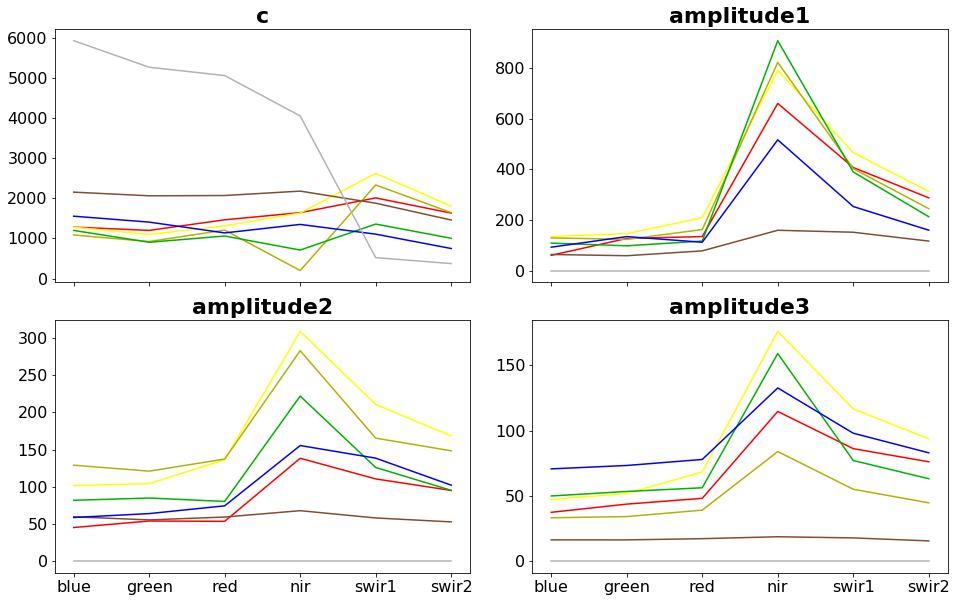

In [7]:
"""
Script to analyse the spectral signature of the reference data
"""




coefficients = ['c']
for freq in range(1,4):
    coefficients.append(f'amplitude{freq}')

classes = [
    'Artifical areas',
    'Grass and herb vegetation',
    'Brush vegetation',
    'Tree vegetation',
    'Bare land',
    'Watery areas',
    'Glacier, perpetual snow'
]

colors = [
    '#FF0000',
    '#FFFF00',
    '#B2B200',
    '#00B200',
    '#804D33',
    '#0000FF',
    '#B2B2B2'
]

""" //////////////////////// main //////////////////////// """




fontsize_title = 22
fontsize = 16


n_plots = len(spectral_bands)
n_rows, n_columns = (2,2)
fig, axs = plt.subplots(n_rows,n_columns, figsize=(16,10), facecolor='w', edgecolor='k', sharex=True)
plt.rcParams.update({'font.size': fontsize, 'axes.labelsize': fontsize, 'axes.titlesize': fontsize })
fig.subplots_adjust(hspace=0.15, wspace=0.15)
axs = axs.ravel()



# iterate over the temporal features and generate plot for each one
for icoef, coef in enumerate(coefficients):
    
    ax = axs[icoef]
    lines = []
    
    for class_, class_name in enumerate(classes):
        
        class_means, class_medians, class_stds = ([],[],[])
        df_class = data[data[label]==class_]
        
        for band in spectral_bands:
            values = np.array(df_class[f'{coef}_{band}'])
            class_means.append(np.mean(values))
            class_medians.append(np.median(values))
            class_stds.append(np.std(values))


        lines += ax.plot([i for i in range(6)], class_means, label=class_name, color=colors[class_])

    

    ax.set_title(
        coefficients[icoef],
        fontdict={'size': fontsize_title, 'weight': 'bold'}
    )
    
    ax.set_xticks([i for i in range(6)])
    ax.set_xticklabels(spectral_bands, fontdict={'fontsize': fontsize})
    


# axs[1].set_axis_off()
# axs[1].legend(lines, classes, loc="best", frameon=False)
# fig.text(0.5, 0.08, 'DOY', ha='center',fontweight='bold',fontsize=fontsize)
# fig.text(0.07, 0.5, 'Surface reflectance', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)

plt.savefig(f'reference_data.png', dpi=300, bbox_inches = "tight")
plt.show()
    
    # end of plotting loop

In [11]:
"""
Script to create a table that summarizes the reference data
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

rois = ['roi1','roi2','roi3']
label = 'land_cover'

list_dfs = []
for roi in rois:
    file_name = f'D:/thesis/scripts/data/arealstatistik/{roi}/{roi}_as_labeled.csv'
    df = pd.read_csv(file_name)
    df['roi'] = roi
    list_dfs.append(df)

data = pd.concat(list_dfs)

stats_lc_total = data.groupby([label]).size()
stats_rois_total = data.groupby(['roi']).size()
stats_rois = data.groupby([label, 'roi']).size()
print(stats_lc_total)
print(stats_rois_total)
print(stats_rois)


land_cover
0    13279
1    28634
2     6679
3    28000
4    17765
5     6879
6     2264
dtype: int64
roi
roi1    34500
roi2    34500
roi3    34500
dtype: int64
land_cover  roi 
0           roi1    11941
            roi2      734
            roi3      604
1           roi1    10244
            roi2    10986
            roi3     7404
2           roi1     1006
            roi2     1956
            roi3     3717
3           roi1     8868
            roi2    13548
            roi3     5584
4           roi1      253
            roi2     3271
            roi3    14241
5           roi1     2188
            roi2     4005
            roi3      686
6           roi3     2264
dtype: int64


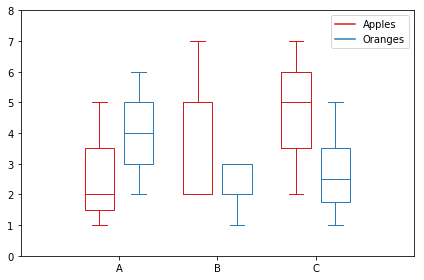

In [3]:
import matplotlib.pyplot as plt
import numpy as np

data_a = [[1,2,5], [5,7,2,2,5], [7,2,5]]
data_b = [[6,4,2], [1,2,5,3,2], [2,3,5,1]]

ticks = ['A', 'B', 'C']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Apples')
plt.plot([], c='#2C7BB6', label='Oranges')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.ylim(0, 8)
plt.tight_layout()
plt.savefig('boxcompare.png')

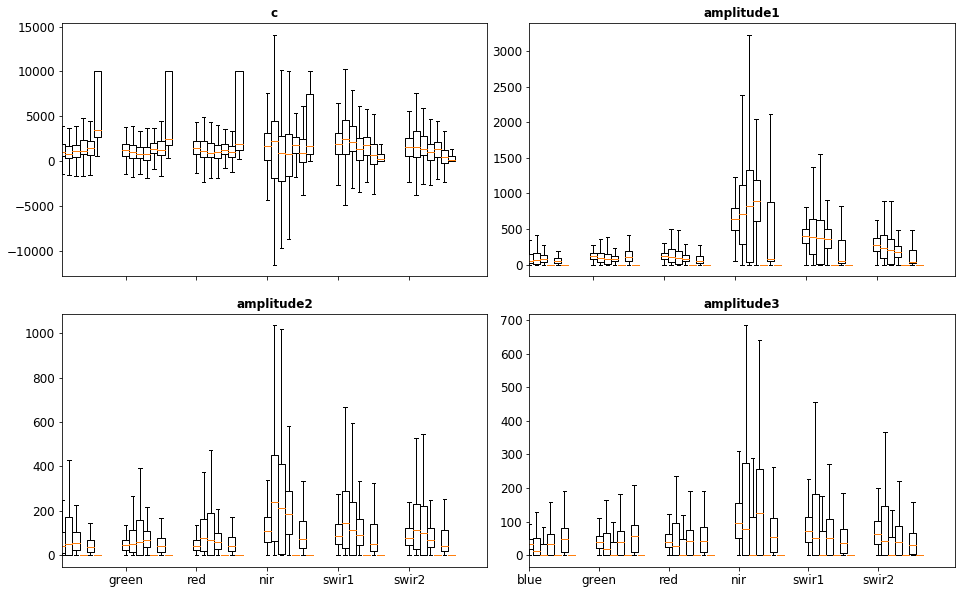

In [20]:
"""
Script to analyse the spectral signature of the reference data
"""




coefficients = ['c']
for freq in range(1,4):
    coefficients.append(f'amplitude{freq}')



classes = [
    'Artifical areas',
    'Grass and herb vegetation',
    'Brush vegetation',
    'Tree vegetation',
    'Bare land',
    'Watery areas',
    'Glacier, perpetual snow'
]

colors = [
    '#FF0000',
    '#FFFF00',
    '#B2B200',
    '#00B200',
    '#804D33',
    '#0000FF',
    '#B2B2B2'
]

""" //////////////////////// main //////////////////////// """





fontsize = 12

n_plots = len(spectral_bands)
n_rows, n_columns = (2,2)
fig, axs = plt.subplots(n_rows,n_columns, figsize=(16,10), facecolor='w', edgecolor='k', sharex=True)
plt.rcParams.update({'font.size': fontsize, 'axes.labelsize': fontsize, 'axes.titlesize': fontsize })
fig.subplots_adjust(hspace=0.15, wspace=0.1)
axs = axs.ravel()



# iterate over the temporal features and generate plot for each one
for icoef, coef in enumerate(coefficients):
    
    ax = axs[icoef]
    lines = []
    
    for class_, class_name in enumerate(classes):
        
        class_values = []
        df_class = data[data[label]==class_]
        
        for band in spectral_bands:
            values = list(df_class[f'{coef}_{band}'])
            class_values.append(values)

        lines += ax.boxplot(
            class_values,
            positions=np.array(range(len(spectral_bands)))+(class_*0.1),
            widths=0.1,
            showfliers=False
        )


    

    ax.set_title(
        coefficients[icoef],
        fontdict={'size': fontsize, 'weight': 'bold'}
    )
    
    #ax.set_ylim((0,6000))
    ax.set_xticks([i for i in range(6)])
    ax.set_xticklabels(spectral_bands, fontdict={'fontsize': 12})
    


# axs[1].set_axis_off()
axs[1].legend(lines, classes, loc="best", frameon=False)
# fig.text(0.5, 0.08, 'DOY', ha='center',fontweight='bold',fontsize=fontsize)
# fig.text(0.07, 0.5, 'Surface reflectance', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)

plt.savefig(f'reference_data.png', dpi=300, bbox_inches = "tight")
plt.show()
    
    # end of plotting loop

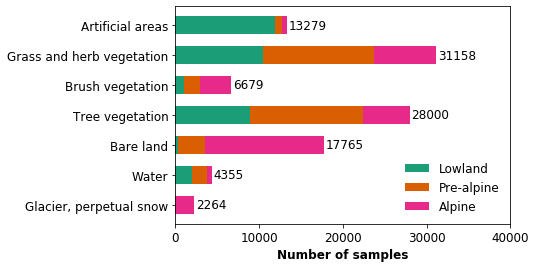

In [83]:
"""
Script to create a plot that summarizes the reference data
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

label = 'land_cover'
rois = ['roi1','roi2','roi3']

df = pd.read_csv('data/labeled_data.csv')

stats = df.groupby(['roi', label]).size()
classes = sorted(df[label].unique())
class_names = [
    'Artificial areas',
    'Grass and herb vegetation',
    'Brush vegetation',
    'Tree vegetation',
    'Bare land',
    'Water',
    'Glacier, perpetual snow'
]
class_names.reverse()

xs = [stats[roi].index.tolist() for roi in rois]
ys = [stats[roi].tolist() for roi in rois]

# adding classes that are not present
new_ys = []
for iroi in range(len(rois)):
    y = []
    for iclass in classes:
        if iclass in xs[iroi]:
            y.append(ys[iroi][xs[iroi].index(iclass)])
        else:
            y.append(0)
    y.reverse()
    new_ys.append(np.array(y))
ys = new_ys


fontsize = 12
plt.rcParams.update({'font.size': fontsize, 'axes.labelsize': fontsize, 'axes.titlesize': fontsize })

# stack bars
bar_width = 0.6
plt.barh(class_names, ys[0], label='Lowland', color='#1b9e77', height=bar_width)
plt.barh(class_names, ys[1], left=ys[0], label='Pre-alpine', color='#d95f02', height=bar_width)
plt.barh(class_names, ys[2], left=ys[0]+ys[1], label='Alpine', color='#e7298a', height=bar_width)

for xpos, ypos in zip(classes, ys[0]+ys[1]+ys[2]):
    plt.text(ypos+200, xpos, f'{ypos}', va='center')

plt.xlim([0,40000])
plt.xticks(range(0,40001,10000))
plt.xlabel('Number of samples',fontweight='bold')
plt.legend(loc='lower right', frameon=False)
plt.savefig(f'reference_data.png', dpi=300, bbox_inches = "tight")
plt.show()    